### PREVIOUSLY:
- Fixed mask generation in Unity; built basic unet_learner; best without transfer;
- Started assembling unity hook; server running ok; made the test functions. Problem - cant make a fastapi response with a picture; trying base64 encoding but something fails...
### TODO:
- Generate 5k images; train on that
- Make Unity hook
- Train via "go big" method; turn off some batch augmentations / image tmfs
- pass accuracy / probability to via API Unity
- build my own Unet?

### Tried:
- Resnet 50; resnet 14, but 50 is too big; 14 seems too inaccurate;
- Transfer learning sucked
- <500 images dont train good; 1k images are already ok
- had problems with different image encodings in Unity and fastai; read through PILMask code in fastai to figure it out; it was a Unity issue in labeling had to be linear encoding

### Imports

In [1]:
import pandas as pd
from fastai.vision.all import *
#from fastai.utils.mem import *

In [2]:
import pathlib
import os
import PIL
from numpy import asarray

In [3]:
path = pathlib.Path().absolute()
path = os.path.join(path, "Assets", "Data~")
def label_func(fn): return os.path.join(path,"labels",f"{fn.stem}{fn.suffix}")
path

'/home/carrotpie/code/classB/SegmentationLearner/Assets/Data~'

In [4]:
codes = pd.read_csv(os.path.join(path,'labels.csv'))
#codes.head()
#codes.shape

In [5]:
fnames = get_image_files(os.path.join(path,"screenshots"))
fnames[0]

Path('/home/carrotpie/code/classB/SegmentationLearner/Assets/Data~/screenshots/2831.png')

In [6]:
lnames = get_image_files(os.path.join(path,"labels"))
lnames[0]

Path('/home/carrotpie/code/classB/SegmentationLearner/Assets/Data~/labels/2831.png')

# Data Loading

In [7]:
room_dblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes.LabelName)),
                   get_items = get_image_files,
                   get_y = label_func,
                   splitter=RandomSplitter(),
                   batch_tfms=aug_transforms(size=(64,64)))#(120,160)))

In [8]:
dls = room_dblock.dataloaders(os.path.join(path,"screenshots"), path=path, bs=4)

In [9]:
#dls = SegmentationDataLoaders.from_label_func(
#    path, bs=8, fnames = fnames, label_func = label_func, codes=codes.LabelName,item_tfms=Resize(256)
#)

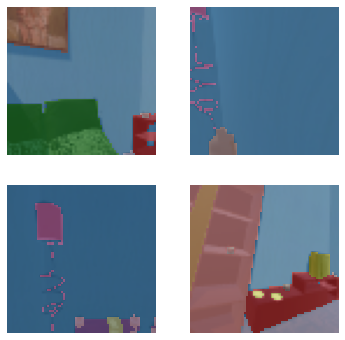

In [10]:
dls.show_batch(vmin=0, vmax=25, cmap='tab20')

## Debuging loaded label images

### See if superimposed is correct

In [11]:
#test how mask is shown, from: https://docs.fast.ai/vision.core.html
cam_fn = fnames[0]
mask_fn = lnames[0]

mask_f = Image.open(mask_fn, mode = 'r')

In [12]:
mask_f = asarray(mask_f)
print(mask_f.shape)

(480, 640)


In [13]:
print(mask_fn)
print(cam_fn)

/home/carrotpie/code/classB/SegmentationLearner/Assets/Data~/labels/2831.png
/home/carrotpie/code/classB/SegmentationLearner/Assets/Data~/screenshots/2831.png


In [14]:
cam_img = PILImage.create(cam_fn)
test_eq(cam_img.size, (640,480))
tmask = Transform(PILMask.create)
mask = tmask(mask_fn)
test_eq(type(mask), PILMask)
test_eq(mask.size, (640,480))

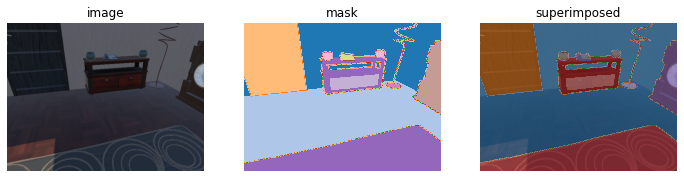

In [15]:
_,axs = plt.subplots(1,3, figsize=(12,3))
cam_img.show(ctx=axs[0], title='image')
mask.show(alpha=1, ctx=axs[1], vmin=0, vmax=25, title='mask')
cam_img.show(ctx=axs[2], title='superimposed')
mask.show(ctx=axs[2], vmin=1, vmax=30);

<AxesSubplot:>

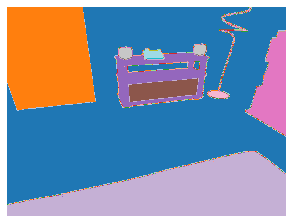

In [16]:
mask = PILMask.create(label_func(fnames[0]))
mask.show(figsize=(5, 5), alpha=1, cmap='tab20')

### Check if any labels are missing unintentionally

In [17]:
def n_code(fname):
    vals = set()
    msk = np.array(load_image(fname)) #PILMask.create
    for val in np.unique(msk):
      if val not in vals:
        vals.add(val)
    return vals

def n_codes(fnames, is_partial=False):
  "Gather the codes from a list of `fnames`"
  vals = set()
  if is_partial:
    random.shuffle(fnames)
    fnames = fnames[:10]
  for fname in fnames:
    vals.update(n_code(fname))
  vals = list(vals)
  p2c = dict()
  for i,val in enumerate(vals):
    p2c[i] = vals[i]
  return p2c

def mask_check(lname):
    msk = np.array(PILMask.create(lname))
    return np.unique(msk)

In [18]:
len_codes = n_codes(lnames)
vals = [v-1 for k, v in len_codes.items()]
#len_codes

In [19]:
#find an out of bounds label name:
for fname in lnames:
    [print(fname, "  label!?:", v) for v in n_code(fname) if v > len(len_codes)+5]

In [20]:
if(len(len_codes) == len(codes.LabelName)):
    print("OK! All items appeared in the dataset! OK!")
else:
    print("Not all items appeared inside the dataset! Please generate larges picture set!")
    print("Missing:")
    codes_mask = ~codes["LabelName"].index.isin(vals)
    print(codes["LabelName"][codes_mask])

Not all items appeared inside the dataset! Please generate larges picture set!
Missing:
Series([], Name: LabelName, dtype: object)


In [21]:
#Check if PILMask doesnt ruin something. These must match:
print(mask_check(lnames[0]))
print(n_code(lnames[0]))

[ 1  2  4 10 11 12 14 15 17 22]
{1, 2, 4, 10, 11, 12, 14, 15, 17, 22}


In [22]:
#Detections:
#codes["LabelName"][mask_check(lnames[0])]

### If needed, print a mask value
Helper function to show a picture with a precise mask pixel value.

In [23]:
def debug_label(img, pixel_id):
    im = Image.open(label_func(img))
    pix = im.load()
    print(im.size)
    print(im.getdata())
    for i in range(len(list(im.getdata(band=0)))):
        x = i % 640
        y = int(i / 640)
        if(pix[x, y] == pixel_id):
            pix[x, y] = 255
            #pix[x, y] = (0, 255, 0, 255)
    im.show()

Show by opening the file in the viewer:

In [24]:
debug_label(lnames[0], 1)

(640, 480)


In [25]:
#See mask color schema
#plt.imshow(np.array([[0, 1, 2, 4, 5, 6]]), vmin=0, vmax=6, cmap='tab20')

# Training

In [26]:
learn = unet_learner(dls, resnet34, pretrained = False, moms=(0.85, 0.75, 0.85), n_out=len(len_codes)+1, metrics=[foreground_acc]).to_fp16()

In [27]:
#learn.unfreeze()
#learn.freeze_to(1)

In [28]:
#learn.summary()

In [29]:
#learn.lr_find()

In [30]:
learn.fit_one_cycle(15, slice(3e-5, 5e-3)) #10

epoch,train_loss,valid_loss,foreground_acc,time
0,0.880563,0.739583,0.761771,01:30
1,1.018534,0.675913,0.820628,01:33
2,0.623134,0.480436,0.842730,01:25
3,0.625612,0.590844,0.805367,01:33
4,0.445660,0.316752,0.911801,01:26
5,0.350996,0.234009,0.929558,01:25
6,0.323658,0.222193,0.935317,01:26
7,0.316357,0.215164,0.929874,01:22
8,0.253973,0.192417,0.940206,01:22
9,0.186429,0.138108,0.956538,01:24


In [31]:
#learn.lr_find()

# Results


#### Metrics helper functions

In [32]:
#Source: https://forums.fast.ai/t/plotting-metrics-after-learning/69937/2
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

#### Metrics Plots

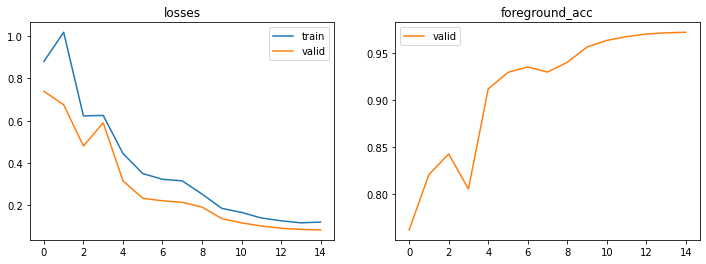

In [33]:
learn.recorder.plot_metrics()

In [34]:
#??learn

In [35]:
#learn.fine_tune(10, 2e-4)

#### Interpertation

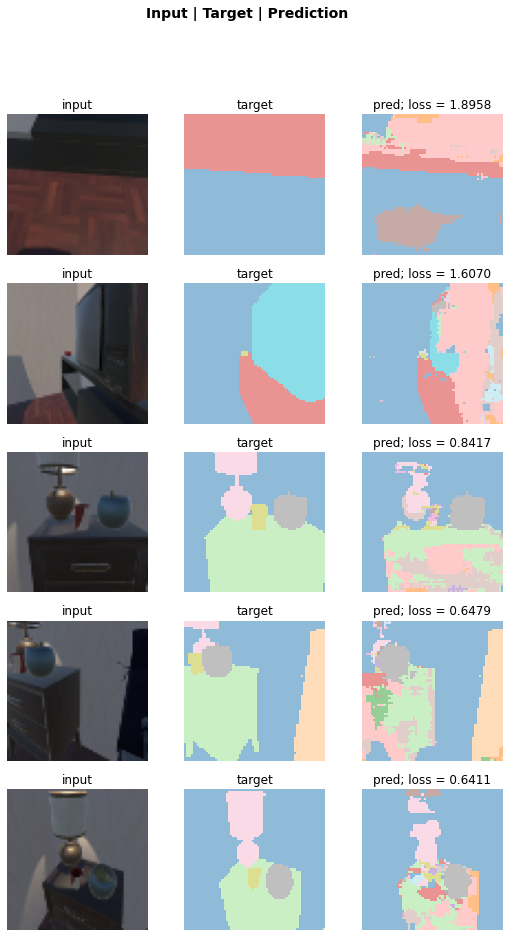

In [36]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=5)

In [37]:
#learn.summary()

In [38]:
#?learn

#### Predicting

In [40]:
from fastai.learner import load_learner
import os
from io import BytesIO
_test_upload_file = ""
for root, dirs, files in os.walk(
    path, topdown=True, onerror=None, followlinks=False
):
    _test_upload_file = os.path.join(root, files[0])
model_path = os.path.join(path, "models", "unity_resnet34")
learner = load_learner(model_path)
print(model_path)
print(_test_upload_file)

/home/carrotpie/code/classB/SegmentationLearner/Assets/Data~/models/unity_resnet34
/home/carrotpie/code/classB/SegmentationLearner/Assets/Data~/screenshots/2831.png


In [41]:
def load_image(data):
    return np.array(PILImage.create(BytesIO(data)))

def path_to_image_bytes(path):
    byteImgIO = io.BytesIO()
    byteImg = Image.open(path)
    byteImg.save(byteImgIO, "PNG")
    byteImgIO.seek(0)
    byteImg = byteImgIO.read()
    #dataBytesIO = io.BytesIO(byteImg)
    
    return byteImg

In [42]:
img_bytes = path_to_image_bytes(_test_upload_file)

image = load_image(img_bytes)

In [44]:
ima = load_image(path_to_image_bytes(_test_upload_file))
print(ima.shape)
#a = np.delete(ima, 3, axis=2)
#print(a.shape)

(480, 640, 3)


<class 'fastai.torch_core.TensorMask'>


<AxesSubplot:>

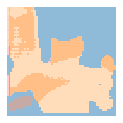

In [45]:
pred = learner.predict(ima)[0]
print(type(pred))
pred.show()

(480, 640)


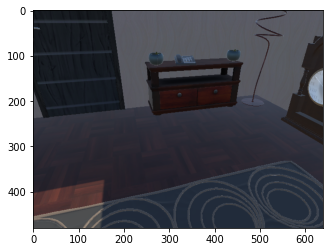

In [59]:
base_img = PILImage.create(fnames[0])
print(base_img.shape)
img_to_learner = np.array(base_img)
plt.imshow(img_to_learner)

<class 'fastai.learner.Learner'>
(480, 640)


<class 'fastai.torch_core.TensorMask'>
torch.Size([64, 64])


<AxesSubplot:>

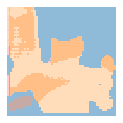

In [60]:
print(type(learner))
print(base_img.shape)
pred = learner.predict(np.array(base_img))[0]
print(type(pred))
print(pred.shape)
pred.show()

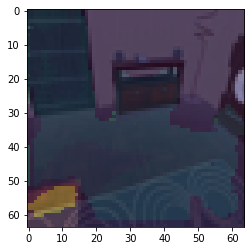

In [61]:
base_img = base_img.resize((64,64))
plt.imshow(np.array(base_img))
plt.imshow(np.array(pred), alpha=0.25)

In [57]:
#print(pred[0].shape)
#pred_1 = pred[0][0]
#print(pred_1)
#pred_argmax = pred_1.argmax(dim=0)
#print(pred_argmax.shape)

In [58]:
#plt.imshow(pred_argmax)

#### Saving model

In [62]:
learn.export('models/unity_resnet34')